___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'/home/ubuntu/Documents/Online_courses/Complete_TF2_and_Keras/Complete-tensorflow2-and-keras-DeepLearning-bootcamp/RNN'

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [4]:
df = pd.read_csv('../Data/RSCCASN.csv',
                index_col='DATE',
                parse_dates=True)

In [5]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.columns = ['Sales']

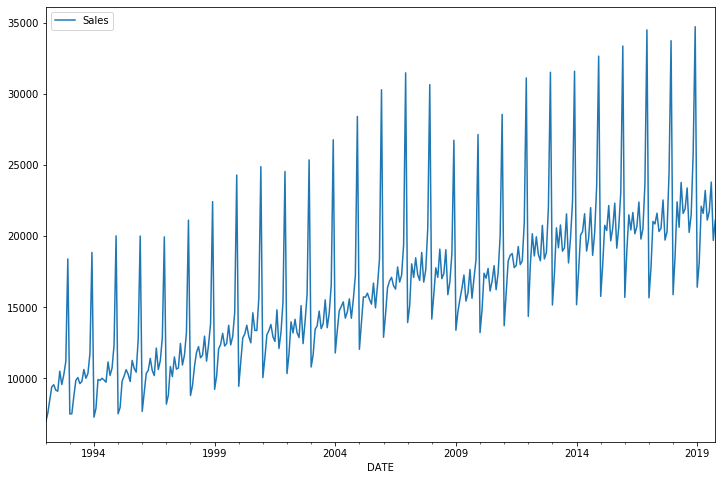

In [7]:
df.plot(figsize=(12,8))

## Train Test Split

In [8]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the fuure

In [9]:
len(df) - 18

316

In [10]:
test_size = 18

In [11]:
test_index = len(df) - test_size

In [12]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [14]:
train.tail()

,Sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [15]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


## Scale Data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [19]:
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# Let's redefine to get 12 months back and then predict the next month out.
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [24]:
# What does the first batch look like?
X,y = generator[0]

In [26]:
print(f'Given the Array: {X.flatten()}')
print(f'Predict this y: {y}')

Given the Array: [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: [[0.02047633]]


## Create the Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [29]:
# We're only using one feature in our time series
n_features = 1

In [31]:
# define model
model = Sequential()
model.add(LSTM(100,activation='relu',
               input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss',
                          patience=2)

In [35]:
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

In [36]:
# fit model
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0255 - val_loss: 0.0037
Epoch 2/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0159 - val_loss: 0.0187
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0012
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0041 - val_loss: 4.7984e-04
Epoch 5/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 6/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0021 - val_loss: 0.0035


In [37]:
losses = pd.DataFrame(model.history.history)

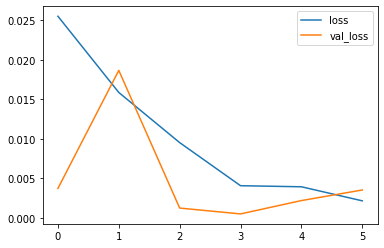

In [38]:
losses.plot()

## Evaluate on Test Data

In [39]:
first_eval_batch = scaled_train[-length:]

In [40]:
first_eval_batch = first_eval_batch.reshape(1,length,n_features)

In [41]:
model.predict(first_eval_batch)

array([[0.5723366]], dtype=float32)

In [42]:
scaled_test[0]

array([0.61087714])

Now let's put this logic in a for loop to predict into the future for the entire test range.
___


In [43]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],
                             [[current_pred]],
                             axis=1)

## Inverse Transformations and Compare

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
test['Predictions'] = true_predictions

/home/ubuntu/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22702.439700
2018-06-01,21589,21452.172940
2018-07-01,21919,21704.593696
2018-08-01,23381,23672.192071
2018-09-01,20260,21013.641725
2018-10-01,21473,21695.918687
2018-11-01,25831,26038.565036
2018-12-01,34706,38291.458376
2019-01-01,16410,17398.269432


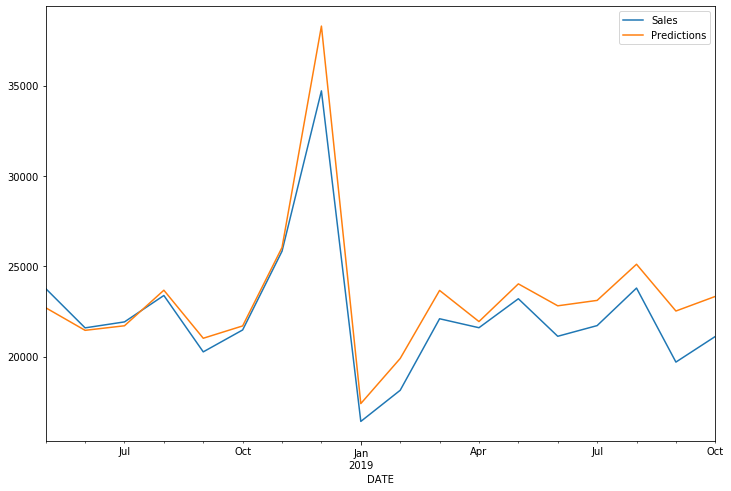

In [47]:
test.plot(figsize=(12,8))

## Retrain and Forecasting

In [48]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [49]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data,
                               scaled_full_data,
                               length = length,
                               batch_size = 1)

In [50]:
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0268
Epoch 2/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0192
Epoch 3/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0114
Epoch 4/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0060
Epoch 5/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0036
Epoch 6/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0022
Epoch 7/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0016


In [51]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Creating new timestamp index with pandas

In [52]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [53]:
forecast_index = pd.date_range(start='2019-11-01',
                              end=periods,
                              freq='MS')

In [55]:
forecast_df = pd.DataFrame(data=forecast,
                          index=forecast_index)

ValueError: Shape of passed values is (12, 1), indices imply (0, 1)